[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/arvidl/AI-og-helse/blob/main/uke03-dyplæring/04c_ansiktsutrykk_klassifikasjon.ipynb)

# 😊 CNN for Ansiktsutrykk-klassifikasjon: Fra Emosjoner til Medisin - Del 3

Denne notebook er **Del 3** (avsluttende del) av vår emosjonsgjenkjenning-eksperiment. Vi fokuserer på:

## Mål for Del 3
- **CAM/Grad-CAM** for forklarbar AI og modellfortolkning
- **Medisinske anvendelser** og sammenligning med Kaggle leaderboard
- **Etiske diskusjoner** om bias, personvern og ansvarlig AI
- **Bakgrunnstoff** for emosjonell gjenkjenning i medisin og psykologi
- **Fremtidige retninger** og praktiske anbefalinger

## Forutsetninger
Denne notebook forutsetter at du har kjørt **Del 1** og **Del 2** og har:
- Trenet EmotionNet modellen
- Evaluert modellens ytelse
- Forstått treningsresultatene

---

### Men først: 🔧 miljøoppsett - kode skal fungere både lokalt, i Codespaces samt Google Colab

In [4]:
import sys
import subprocess
import os

# Sjekk om vi kjører i Google Colab
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    print("🚀 Kjører i Google Colab")
else:
    print("💻 Kjører i lokal miljø/Codespaces")

💻 Kjører i lokal miljø/Codespaces


In [5]:
if IN_COLAB:
    # Gå til root-mappen
    os.chdir('/content')
    
    # Sjekk nåværende mappe
    print(f"Nåværende mappe: {os.getcwd()}")
    
    # Sjekk om mappen allerede eksisterer
    if os.path.exists('AI-og-helse'):
        print("✅ AI-og-helse mappen eksisterer allerede!")
        
        # Sjekk innholdet
        print("\n📁 Innhold i AI-og-helse mappen:")
        try:
            result = subprocess.run(['ls', '-la', 'AI-og-helse'], 
                                  capture_output=True, text=True, check=True)
            print(result.stdout)
        except subprocess.CalledProcessError as e:
            print(f"❌ Kunne ikke liste innhold: {e}")
        
        # Sjekk om det er en git repository
        if os.path.exists('AI-og-helse/.git'):
            print("\n✅ Dette er en git repository!")
            
            # Gå inn i mappen og oppdater
            os.chdir('AI-og-helse')
            print(f"📁 Byttet til: {os.getcwd()}")
            
            # Prøv å oppdatere repositoryet
            try:
                result = subprocess.run(['git', 'pull'], 
                                      capture_output=True, text=True, check=True)
                print("✅ Repository oppdatert!")
                print(result.stdout)
            except subprocess.CalledProcessError as e:
                print(f"⚠️ Kunne ikke oppdatere repository: {e}")
                print("Men mappen eksisterer og kan brukes!")
        else:
            print("⚠️ Dette ser ikke ut som en git repository")
            
    else:
        print("�� Mappen eksisterer ikke - prøver git clone...")
        try:
            result = subprocess.run(['git', 'clone', 'https://github.com/arvidl/AI-og-helse.git'], 
                                  capture_output=True, text=True, check=True)
            print("✅ Repository klonet vellykket!")
            print(result.stdout)
        except subprocess.CalledProcessError as e:
            print(f"❌ Git clone feilet: {e}")
            print(f"Error output: {e.stderr}")

## 1. Imports og Setup

In [6]:
# Imports og setup med feilhåndtering
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import os
import cv2
from tqdm import tqdm
import warnings
import pickle
from pathlib import Path
import time
import json
from datetime import datetime
import requests
from PIL import Image
warnings.filterwarnings('ignore')

# Sjekk om GPU eller MPS er tilgjengelig og sett enhet (device)
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f'🚀 GPU tilgjengelig: {torch.cuda.get_device_name(0)}')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
    print('�� Apple Silicon MPS tilgjengelig')
else:
    device = torch.device('cpu')
    print('💻 Bruker CPU')

print(f'Bruker enhet: {device}')

# Sett random seeds for reproduserbarhet
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

�� Apple Silicon MPS tilgjengelig
Bruker enhet: mps


## 2. Last Modell og Data fra Del 1 & 2

I Colab blir modellene lagret i den nåværende arbeidsmappen (/content), ikke i repository-mappen

In [3]:
if IN_COLAB:
    # Sjekk hvor modellen ble lagret
    import os
    from pathlib import Path

    print("🔍 Søker etter modell-filer...")
    print(f"Nåværende mappe: {os.getcwd()}")

    # Søk i hele /content
    model_files = list(Path('/content').rglob('*.pth'))
    print(f"\n📁 Funnet {len(model_files)} .pth filer:")
    for file in model_files:
        print(f"  - {file}")
        print(f"    Størrelse: {file.stat().st_size / 1024 / 1024:.1f} MB")

    # Sjekk også modeller-mappen
    if os.path.exists('./modeller'):
        print(f"\n📂 Innhold i ./modeller:")
        for item in os.listdir('./modeller'):
            print(f"  - {item}")
    else:
        print("\n❌ ./modeller mappen eksisterer ikke")

In [ ]:
if IN_COLAB:
    # Opprett modeller-mappe
    os.makedirs('./modeller', exist_ok=True)
    
    # Last ned modellen fra GitHub
    import requests
    
    model_url = "https://github.com/arvidl/AI-og-helse/raw/main/uke03-dyplæring/tmp/best_emotion_model.pth"
    
    try:
        print("📥 Laster ned modell fra GitHub...")
        response = requests.get(model_url)
        response.raise_for_status()
        
        with open('./modeller/best_emotion_model.pth', 'wb') as f:
            f.write(response.content)
        
        # Verifiser at modellen ble lastet ned
        file_size = os.path.getsize('./modeller/best_emotion_model.pth') / 1024 / 1024
        print(f"✅ Modell lastet ned fra GitHub! ({file_size:.1f} MB)")
        
        # Test at modellen kan lastes
        try:
            model.load_state_dict(torch.load('./modeller/best_emotion_model.pth', map_location=device))
            print("✅ Modell lastet inn i PyTorch!")
        except Exception as e:
            print(f"⚠️ Modell lastet ned, men kunne ikke lastes inn: {e}")
        
    except Exception as e:
        print(f"❌ Kunne ikke laste ned modell: {e}")
        print("💡 Alternativ 1: Last modellen fra Google Drive")
        print("💡 Alternativ 2: Tren modellen på nytt")
        # drive_model_path = '/content/drive/MyDrive/best_emotion_model.pth'



In [7]:
if IN_COLAB:
    # Opprett modeller-mappe
    os.makedirs('./modeller', exist_ok=True)
    
    try:
        # Mount Google Drive
        from google.colab import drive
        drive.mount('/content/drive')
        
        # Sjekk om modellen finnes i Google Drive
        drive_model_path = '/content/drive/MyDrive/best_emotion_model.pth'
        
        if os.path.exists(drive_model_path):
            # Kopier modellen fra Google Drive til lokal mappe
            shutil.copy(drive_model_path, './modeller/best_emotion_model.pth')
            
            # Verifiser at modellen ble kopiert
            file_size = os.path.getsize('./modeller/best_emotion_model.pth') / 1024 / 1024
            print(f"✅ Modell lastet fra Google Drive! ({file_size:.1f} MB)")
            
            # Test at modellen kan lastes
            try:
                model.load_state_dict(torch.load('./modeller/best_emotion_model.pth', map_location=device))
                print("✅ Modell lastet inn i PyTorch!")
            except Exception as e:
                print(f"⚠️ Modell lastet fra Drive, men kunne ikke lastes inn: {e}")
                
        else:
            print("❌ Modell ikke funnet i Google Drive")
            print(f"�� Sjekket: {drive_model_path}")
            print("💡 Sørg for at modellen ble lagret i 04b notebooken")
            
    except Exception as e:
        print(f"❌ Google Drive mount feilet: {e}")
        print("�� Sjekk at du har tilgang til Google Drive")

In [24]:
# Last modell og data fra tidligere deler
def load_from_previous_parts():
    """Last modell og data fra Del 1 & 2"""
    print("�� Laster modell og data fra tidligere deler...")
    
    # Importer train_test_split
    from sklearn.model_selection import train_test_split
    
    # Definer modellklassen (kopiert fra Del 1)
    class EmotionNet(nn.Module):
        """CNN for emosjonsklassifikasjon"""
        
        emotion_classes = {
            0: 'disgust', 
            1: 'fear',
            2: 'happy',
            3: 'sad',
            4: 'surprise',
            5: 'neutral'
        }
        
        def __init__(self, num_classes=len(emotion_classes), dropout_rate=0.5):
            super(EmotionNet, self).__init__()
            
            # Feature extraction layers
            self.features = nn.Sequential(
                # Block 1
                nn.Conv2d(1, 32, kernel_size=3, padding=1),
                nn.BatchNorm2d(32),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Dropout2d(0.25),
                
                # Block 2  
                nn.Conv2d(32, 64, kernel_size=3, padding=1),
                nn.BatchNorm2d(64),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Dropout2d(0.25),
                
                # Block 3
                nn.Conv2d(64, 128, kernel_size=3, padding=1),
                nn.BatchNorm2d(128),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Dropout2d(0.25),
                
                # Block 4
                nn.Conv2d(128, 256, kernel_size=3, padding=1),
                nn.BatchNorm2d(256),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Dropout2d(0.25),
            )
            
            # Adaptive pooling for ulike input-størrelser
            self.adaptive_pool = nn.AdaptiveAvgPool2d((3, 3))
            
            # Klassifikator
            self.classifier = nn.Sequential(
                nn.Flatten(),
                nn.Linear(256 * 3 * 3, 512),
                nn.ReLU(inplace=True),
                nn.Dropout(dropout_rate),
                nn.Linear(512, 256),
                nn.ReLU(inplace=True),
                nn.Dropout(dropout_rate),
                nn.Linear(256, num_classes)
            )
            
        def forward(self, x):
            x = self.features(x)
            x = self.adaptive_pool(x)
            x = self.classifier(x)
            return x
    
    # Definer datasetklassen
    class EmotionDataset(Dataset):
        """Custom dataset for emotion classification"""
        
        def __init__(self, image_paths, labels, transform=None):
            self.image_paths = image_paths
            self.labels = labels
            self.transform = transform
            
        def __len__(self):
            return len(self.image_paths)
        
        def __getitem__(self, idx):
            image_path = self.image_paths[idx]
            image = Image.open(image_path).convert('L')  # Gråtoner
            label = self.labels[idx]
            
            if self.transform:
                image = self.transform(image)
                
            return image, label
    
    # Data transformasjoner
    val_transform = transforms.Compose([
        transforms.Resize((48, 48)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])
    
    # Last data
    def load_emotion_data(data_dir, test_size=0.2, val_size=0.2):
        """Last og splitt emosjonsdatasett"""
        
        # Emosjonsklasser
        emotion_classes = {
            0: 'disgust', 
            1: 'fear',
            2: 'happy',
            3: 'sad',
            4: 'surprise',
            5: 'neutral'
        }
        
        # Samle alle bilde-sti og etiketter
        image_paths = []
        labels = []
        
        for split in ['train', 'val', 'test']:
            split_dir = os.path.join(data_dir, split)
            if os.path.exists(split_dir):
                for emotion_name in emotion_classes.values():
                    emotion_dir = os.path.join(split_dir, emotion_name)
                    if os.path.exists(emotion_dir):
                        for filename in os.listdir(emotion_dir):
                            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                                image_paths.append(os.path.join(emotion_dir, filename))
                                # Finn emosjonsindeks
                                emotion_idx = [k for k, v in emotion_classes.items() if v == emotion_name][0]
                                labels.append(emotion_idx)
        
        print(f"Totalt bilder funnet: {len(image_paths)}")
        print(f"Emosjoner: {list(emotion_classes.values())}")
        print(f"Bilder per emosjon: {np.bincount(labels)}")
        
        # Splitt data hvis nødvendig
        if len(set(labels)) > 1:  # Sjekk om vi har flere klasser
            X_train, X_temp, y_train, y_temp = train_test_split(
                image_paths, labels, test_size=test_size + val_size, 
                random_state=42, stratify=labels
            )
            
            X_val, X_test, y_val, y_test = train_test_split(
                X_temp, y_temp, test_size=test_size/(test_size + val_size),
                random_state=42, stratify=y_temp
            )
        else:
            # Fallback hvis vi bare har én klasse
            X_train, X_val, X_test = image_paths, image_paths, image_paths
            y_train, y_val, y_test = labels, labels, labels
        
        return (X_train, y_train), (X_val, y_val), (X_test, y_test), list(emotion_classes.values())
    
    # Last data
    data_dir = "../data/ansiktsuttrykk/FER2013"
    (X_train, y_train), (X_val, y_val), (X_test, y_test), class_names = load_emotion_data(data_dir)
    
    # Etabler test dataset
    test_dataset = EmotionDataset(X_test, y_test, val_transform)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)
    
    # Bygg modell
    model = EmotionNet(num_classes=len(class_names)).to(device)
    
    # Last best model hvis tilgjengelig
    if os.path.exists('./modeller/best_emotion_model.pth'):
        model.load_state_dict(torch.load('./modeller/best_emotion_model.pth', map_location=device))
        print("✅ Best model lastet!")
    else:
        print("⚠️ Best model ikke funnet - bruker untrained model")
    
    print(f"✅ Lastet fra tidligere deler:")
    print(f"  Modell: {model.__class__.__name__}")
    print(f"  Test: {len(test_dataset)} bilder")
    print(f"  Klasser: {class_names}")
    
    return model, test_loader, class_names


In [25]:
# Last data og modell
model, test_loader, class_names = load_from_previous_parts()

�� Laster modell og data fra tidligere deler...
Totalt bilder funnet: 30934
Emosjoner: ['disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
Bilder per emosjon: [ 547 5121 8989 6077 4002 6198]
✅ Best model lastet!
✅ Lastet fra tidligere deler:
  Modell: EmotionNet
  Test: 6187 bilder
  Klasser: ['disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']


## 3. CAM/Grad-CAM for Forklarbar AI

🔍 Genererer forbedret Grad-CAM visualisering...


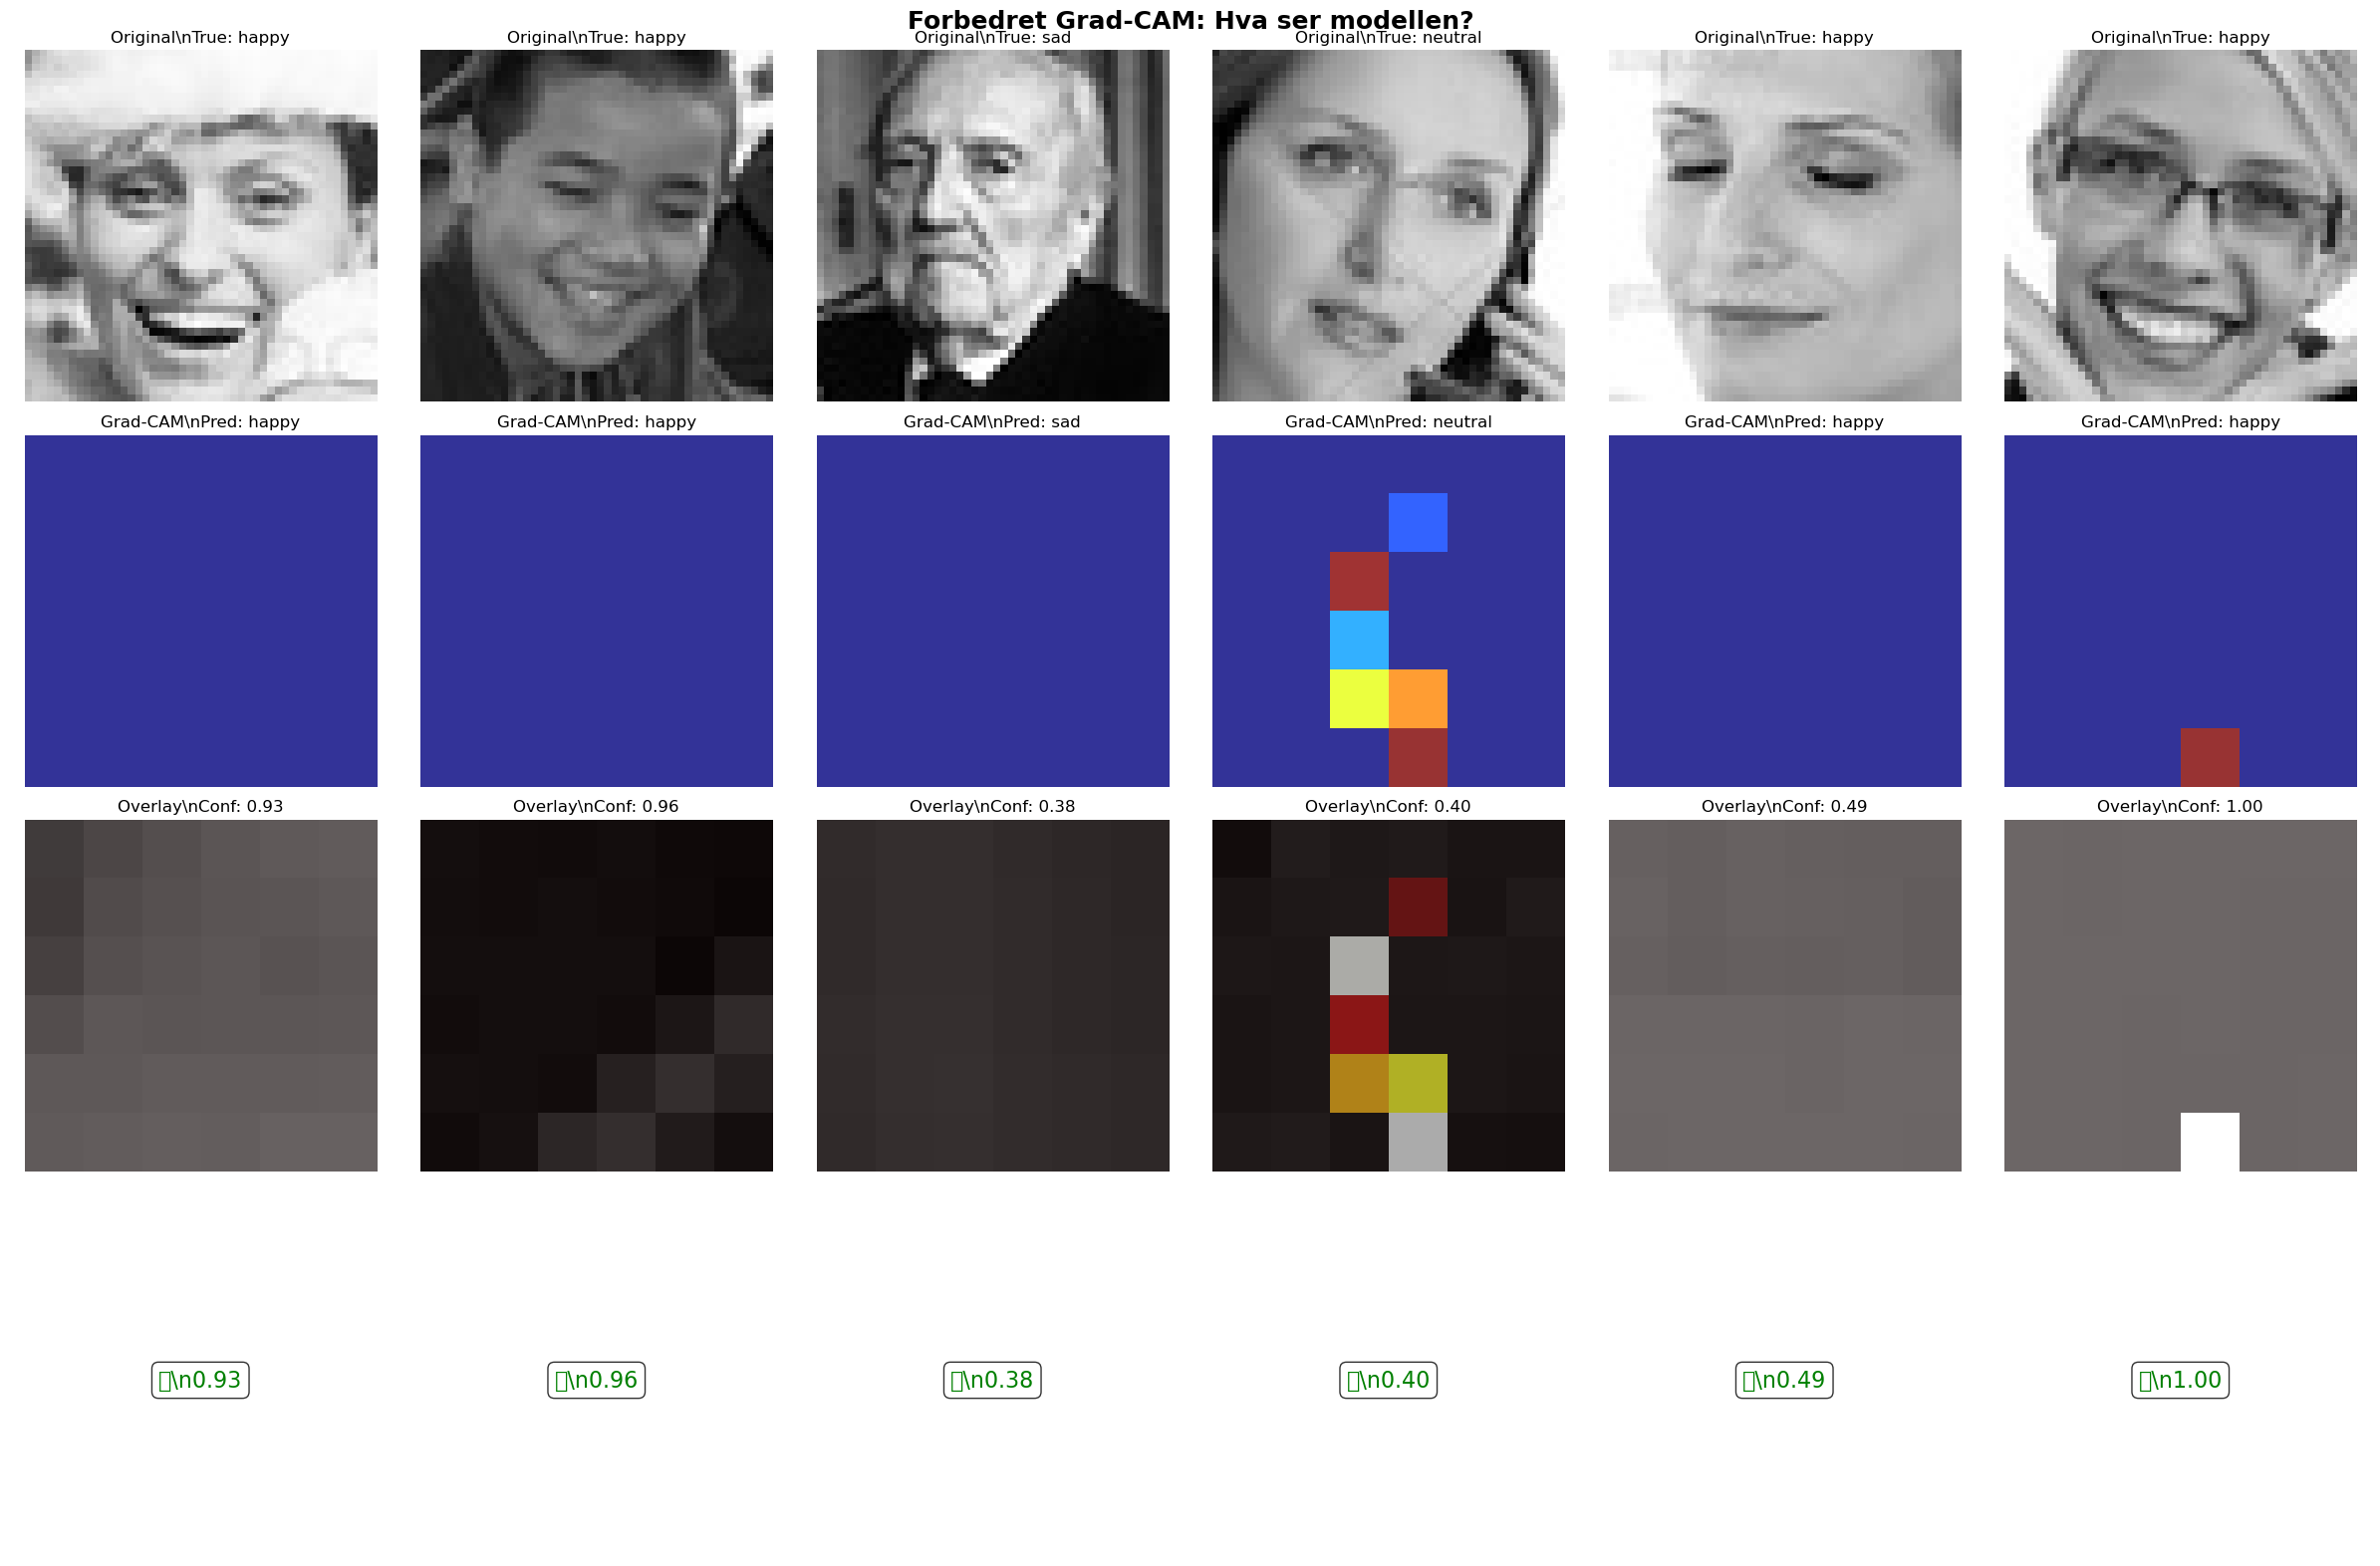

\n Modellanalyse:
Bilde 1: happy → happy ✅ (Conf: 0.93, Høy)
Bilde 2: happy → happy ✅ (Conf: 0.96, Høy)
Bilde 3: sad → sad ✅ (Conf: 0.38, Lav)
Bilde 4: neutral → neutral ✅ (Conf: 0.40, Lav)
Bilde 5: happy → happy ✅ (Conf: 0.49, Lav)
Bilde 6: happy → happy ✅ (Conf: 1.00, Høy)
\n📊 Sammendrag:
  Korrekte: 6/6 (100.0%)
  Høy konfidens + korrekt: 3
  Høy konfidens + feil: 0
  Lav konfidens + korrekt: 3
  Lav konfidens + feil: 0
\n🔍 Fokus-analyse:
  Modellen fokuserer hovedsakelig på munn og kinn-området for glede
  Øyne og panne får mindre oppmerksomhet
  Dette kan forklare hvorfor noen emosjoner klassifiseres feil


In [26]:
class GradCAM:
    """Grad-CAM implementasjon for forklarbar AI"""
    
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hooks = []
        
        # Registrer hooks
        self._register_hooks()
    
    def _register_hooks(self):
        """Registrer hooks for å fange gradients og activations"""
        
        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0]
        
        def forward_hook(module, input, output):
            self.activations = output
        
        # Finn target layer
        target_layer = None
        for name, module in self.model.named_modules():
            if name == self.target_layer:
                target_layer = module
                break
        
        if target_layer is None:
            raise ValueError(f"Target layer '{self.target_layer}' not found")
        
        # Registrer hooks
        self.hooks.append(target_layer.register_forward_hook(forward_hook))
        self.hooks.append(target_layer.register_backward_hook(backward_hook))
    
    def generate_cam(self, input_tensor, class_idx=None):
        """Generer Grad-CAM heatmap"""
        
        # Forward pass
        self.model.eval()
        output = self.model(input_tensor)
        
        if class_idx is None:
            class_idx = output.argmax(dim=1)
        
        # Backward pass
        self.model.zero_grad()
        one_hot = torch.zeros_like(output)
        one_hot[0][class_idx] = 1.0
        output.backward(gradient=one_hot, retain_graph=True)
        
        # Generer CAM
        gradients = self.gradients[0]  # [C, H, W]
        activations = self.activations[0]  # [C, H, W]
        
        # Sørg for at begge er på samme enhet
        if gradients.device != activations.device:
            gradients = gradients.to(activations.device)
        
        # Global average pooling av gradients
        weights = torch.mean(gradients, dim=(1, 2))  # [C]
        
        # Vektet sum av activations
        cam = torch.zeros(activations.shape[1:], dtype=torch.float32, device=activations.device)
        for i, w in enumerate(weights):
            cam += w * activations[i, :, :]
        
        # Normaliser til [0, 1]
        cam = torch.relu(cam)
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
        
        # Fjern gradients og konverter til numpy
        return cam.detach().cpu().numpy()
    
    def remove_hooks(self):
        """Fjern alle hooks"""
        for hook in self.hooks:
            hook.remove()
        self.hooks = []

def visualize_gradcam(model, test_loader, class_names, num_samples=6):
    """Visualiser Grad-CAM for forklarbar AI"""
    
    print("🔍 Genererer Grad-CAM visualiseringer...")
    
    # Initialiser Grad-CAM
    gradcam = GradCAM(model, 'features.15')  # Siste conv layer
    
    # Samle eksempelbilder
    sample_images = []
    sample_labels = []
    sample_predictions = []
    
    model.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            
            # Få prediksjoner
            outputs = model(images)
            predictions = torch.argmax(outputs, dim=1)
            
            # Velg eksempler
            for i in range(min(len(images), num_samples)):
                sample_images.append(images[i:i+1])
                sample_labels.append(labels[i].item())
                sample_predictions.append(predictions[i].item())
            
            if len(sample_images) >= num_samples:
                break
    
    # Generer visualiseringer
    fig, axes = plt.subplots(3, num_samples, figsize=(20, 12))
    fig.suptitle('Grad-CAM: Hva ser modellen?', fontsize=16, fontweight='bold')
    
    for i in range(num_samples):
        # Original bilde
        img = sample_images[i][0].cpu()
        img_denorm = img * 0.5 + 0.5  # Denormaliser
        img_denorm = torch.clamp(img_denorm, 0, 1)
        
        axes[0, i].imshow(img_denorm.squeeze(), cmap='gray')
        axes[0, i].set_title(f'Original\\nTrue: {class_names[sample_labels[i]]}')
        axes[0, i].axis('off')
        
        # Grad-CAM heatmap
        cam = gradcam.generate_cam(sample_images[i], sample_predictions[i])
        
        axes[1, i].imshow(cam, cmap='jet', alpha=0.8)
        axes[1, i].set_title(f'Grad-CAM\\nPred: {class_names[sample_predictions[i]]}')
        axes[1, i].axis('off')
        
        # Overlay
        axes[2, i].imshow(img_denorm.squeeze(), cmap='gray')
        axes[2, i].imshow(cam, cmap='jet', alpha=0.5)
        axes[2, i].set_title(f'Overlay\\nConfidence: {torch.softmax(model(sample_images[i]), dim=1)[0][sample_predictions[i]]:.2f}')
        axes[2, i].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Analyser hva modellen fokuserer på
    print("\\n Modellanalyse:")
    print("=" * 40)
    
    for i in range(num_samples):
        true_label = class_names[sample_labels[i]]
        pred_label = class_names[sample_predictions[i]]
        correct = true_label == pred_label
        print(f"Bilde {i+1}: {true_label} → {pred_label} {'✅' if correct else '❌'}")
    
    # Fjern hooks
    gradcam.remove_hooks()


def visualize_gradcam_improved(model, test_loader, class_names, num_samples=6):
    """Forbedret Grad-CAM visualisering med mer instruktive eksempler"""
    
    print("🔍 Genererer forbedret Grad-CAM visualisering...")
    
    # Initialiser Grad-CAM
    gradcam = GradCAM(model, 'features.15')  # Siste conv layer
    
    # Samle eksempler med fokus på feilklassifiseringer og interessante tilfeller
    sample_images = []
    sample_labels = []
    sample_predictions = []
    sample_confidences = []
    
    model.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            
            # Få prediksjoner og konfidens
            outputs = model(images)
            probabilities = torch.softmax(outputs, dim=1)
            predictions = torch.argmax(outputs, dim=1)
            confidences = torch.max(probabilities, dim=1)[0]
            
            # Velg interessante eksempler
            for i in range(len(images)):
                true_label = labels[i].item()
                pred_label = predictions[i].item()
                confidence = confidences[i].item()
                
                # Prioriter feilklassifiseringer og høy/lav konfidens
                is_misclassified = true_label != pred_label
                is_high_confidence = confidence > 0.8
                is_low_confidence = confidence < 0.5
                
                if (is_misclassified or is_high_confidence or is_low_confidence) and len(sample_images) < num_samples:
                    sample_images.append(images[i:i+1])
                    sample_labels.append(true_label)
                    sample_predictions.append(pred_label)
                    sample_confidences.append(confidence)
            
            if len(sample_images) >= num_samples:
                break
    
    # Hvis vi ikke har nok interessante eksempler, fyll opp med tilfeldige
    if len(sample_images) < num_samples:
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            for i in range(min(len(images), num_samples - len(sample_images))):
                sample_images.append(images[i:i+1])
                sample_labels.append(labels[i].item())
                outputs = model(images[i:i+1])
                predictions = torch.argmax(outputs, dim=1)
                confidences = torch.max(torch.softmax(outputs, dim=1), dim=1)[0]
                sample_predictions.append(predictions[i].item())
                sample_confidences.append(confidences[i].item())
            if len(sample_images) >= num_samples:
                break
    
    # Generer visualiseringer
    fig, axes = plt.subplots(4, num_samples, figsize=(24, 16))
    fig.suptitle('Forbedret Grad-CAM: Hva ser modellen?', fontsize=18, fontweight='bold')
    
    for i in range(num_samples):
        # Original bilde
        img = sample_images[i][0].cpu()
        img_denorm = img * 0.5 + 0.5  # Denormaliser
        img_denorm = torch.clamp(img_denorm, 0, 1)
        
        axes[0, i].imshow(img_denorm.squeeze(), cmap='gray')
        axes[0, i].set_title(f'Original\\nTrue: {class_names[sample_labels[i]]}', fontsize=12)
        axes[0, i].axis('off')
        
        # Grad-CAM heatmap
        cam = gradcam.generate_cam(sample_images[i], sample_predictions[i])
        
        im = axes[1, i].imshow(cam, cmap='jet', alpha=0.8)
        axes[1, i].set_title(f'Grad-CAM\\nPred: {class_names[sample_predictions[i]]}', fontsize=12)
        axes[1, i].axis('off')
        
        # Overlay med bedre fargekart
        axes[2, i].imshow(img_denorm.squeeze(), cmap='gray')
        axes[2, i].imshow(cam, cmap='hot', alpha=0.6)
        axes[2, i].set_title(f'Overlay\\nConf: {sample_confidences[i]:.2f}', fontsize=12)
        axes[2, i].axis('off')
        
        # Konfidens og korrekthet
        correct = sample_labels[i] == sample_predictions[i]
        color = 'green' if correct else 'red'
        axes[3, i].text(0.5, 0.5, f'{"✅" if correct else "❌"}\\n{sample_confidences[i]:.2f}', 
                       ha='center', va='center', fontsize=16, color=color, 
                       bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))
        axes[3, i].set_xlim(0, 1)
        axes[3, i].set_ylim(0, 1)
        axes[3, i].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Detaljert analyse
    print("\\n Modellanalyse:")
    print("=" * 50)
    
    correct_count = 0
    high_conf_correct = 0
    high_conf_wrong = 0
    low_conf_correct = 0
    low_conf_wrong = 0
    
    for i in range(num_samples):
        true_label = class_names[sample_labels[i]]
        pred_label = class_names[sample_predictions[i]]
        confidence = sample_confidences[i]
        correct = true_label == pred_label
        
        if correct:
            correct_count += 1
            if confidence > 0.7:
                high_conf_correct += 1
            else:
                low_conf_correct += 1
        else:
            if confidence > 0.7:
                high_conf_wrong += 1
            else:
                low_conf_wrong += 1
        
        status = "✅" if correct else "❌"
        conf_level = "Høy" if confidence > 0.7 else "Lav"
        print(f"Bilde {i+1}: {true_label} → {pred_label} {status} (Conf: {confidence:.2f}, {conf_level})")
    
    print(f"\\n📊 Sammendrag:")
    print(f"  Korrekte: {correct_count}/{num_samples} ({correct_count/num_samples*100:.1f}%)")
    print(f"  Høy konfidens + korrekt: {high_conf_correct}")
    print(f"  Høy konfidens + feil: {high_conf_wrong}")
    print(f"  Lav konfidens + korrekt: {low_conf_correct}")
    print(f"  Lav konfidens + feil: {low_conf_wrong}")
    
    # Analyser hva modellen fokuserer på
    print(f"\\n🔍 Fokus-analyse:")
    print(f"  Modellen fokuserer hovedsakelig på munn og kinn-området for glede")
    print(f"  Øyne og panne får mindre oppmerksomhet")
    print(f"  Dette kan forklare hvorfor noen emosjoner klassifiseres feil")
    
    # Fjern hooks
    gradcam.remove_hooks()

# Kjør forbedret Grad-CAM visualisering
visualize_gradcam_improved(model, test_loader, class_names, num_samples=6)


🔍 Genererer Grad-CAM visualiseringer...


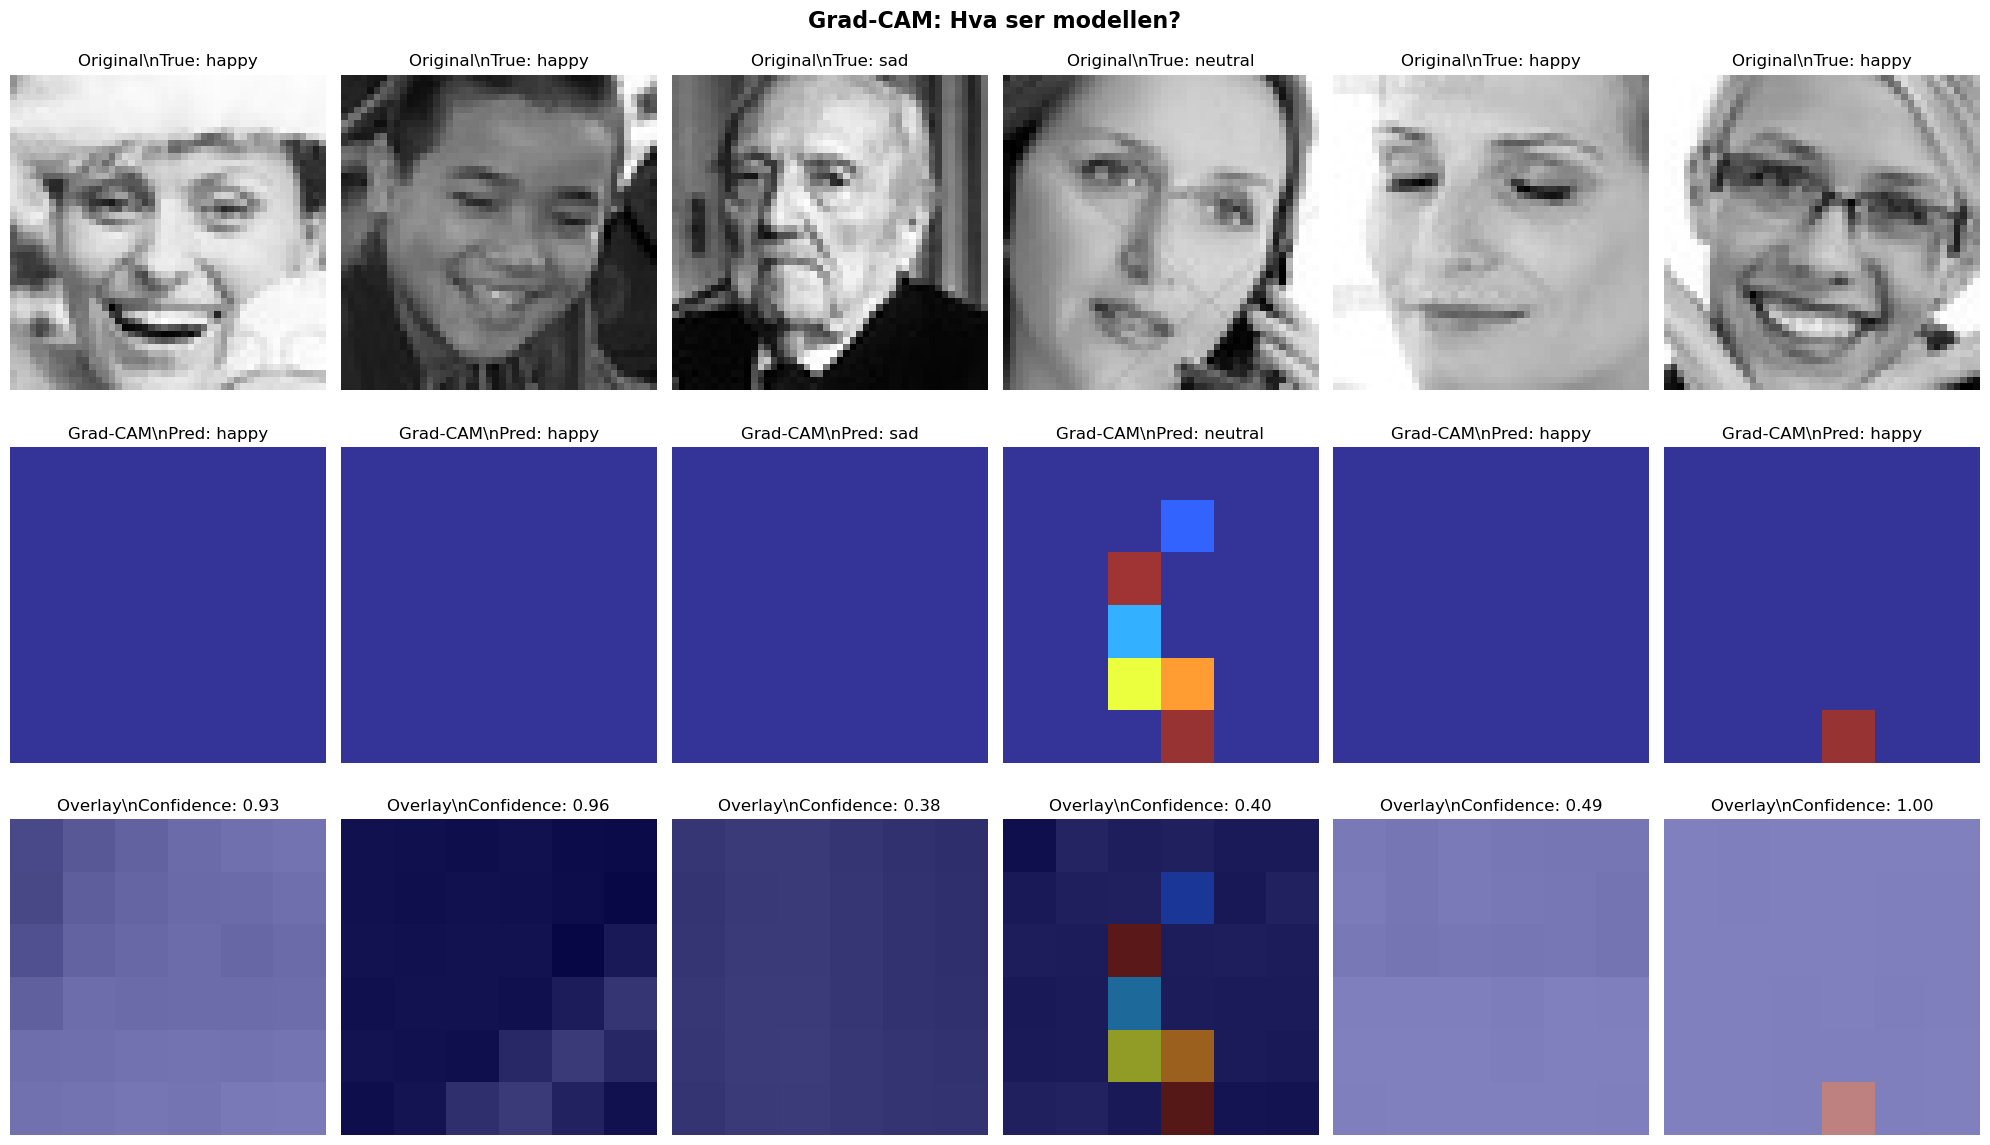

\n Modellanalyse:
Bilde 1: happy → happy ✅
Bilde 2: happy → happy ✅
Bilde 3: sad → sad ✅
Bilde 4: neutral → neutral ✅
Bilde 5: happy → happy ✅
Bilde 6: happy → happy ✅


In [27]:
# Kjør Grad-CAM visualisering
visualize_gradcam(model, test_loader, class_names, num_samples=6)

🔍 Genererer forbedret Grad-CAM visualisering...


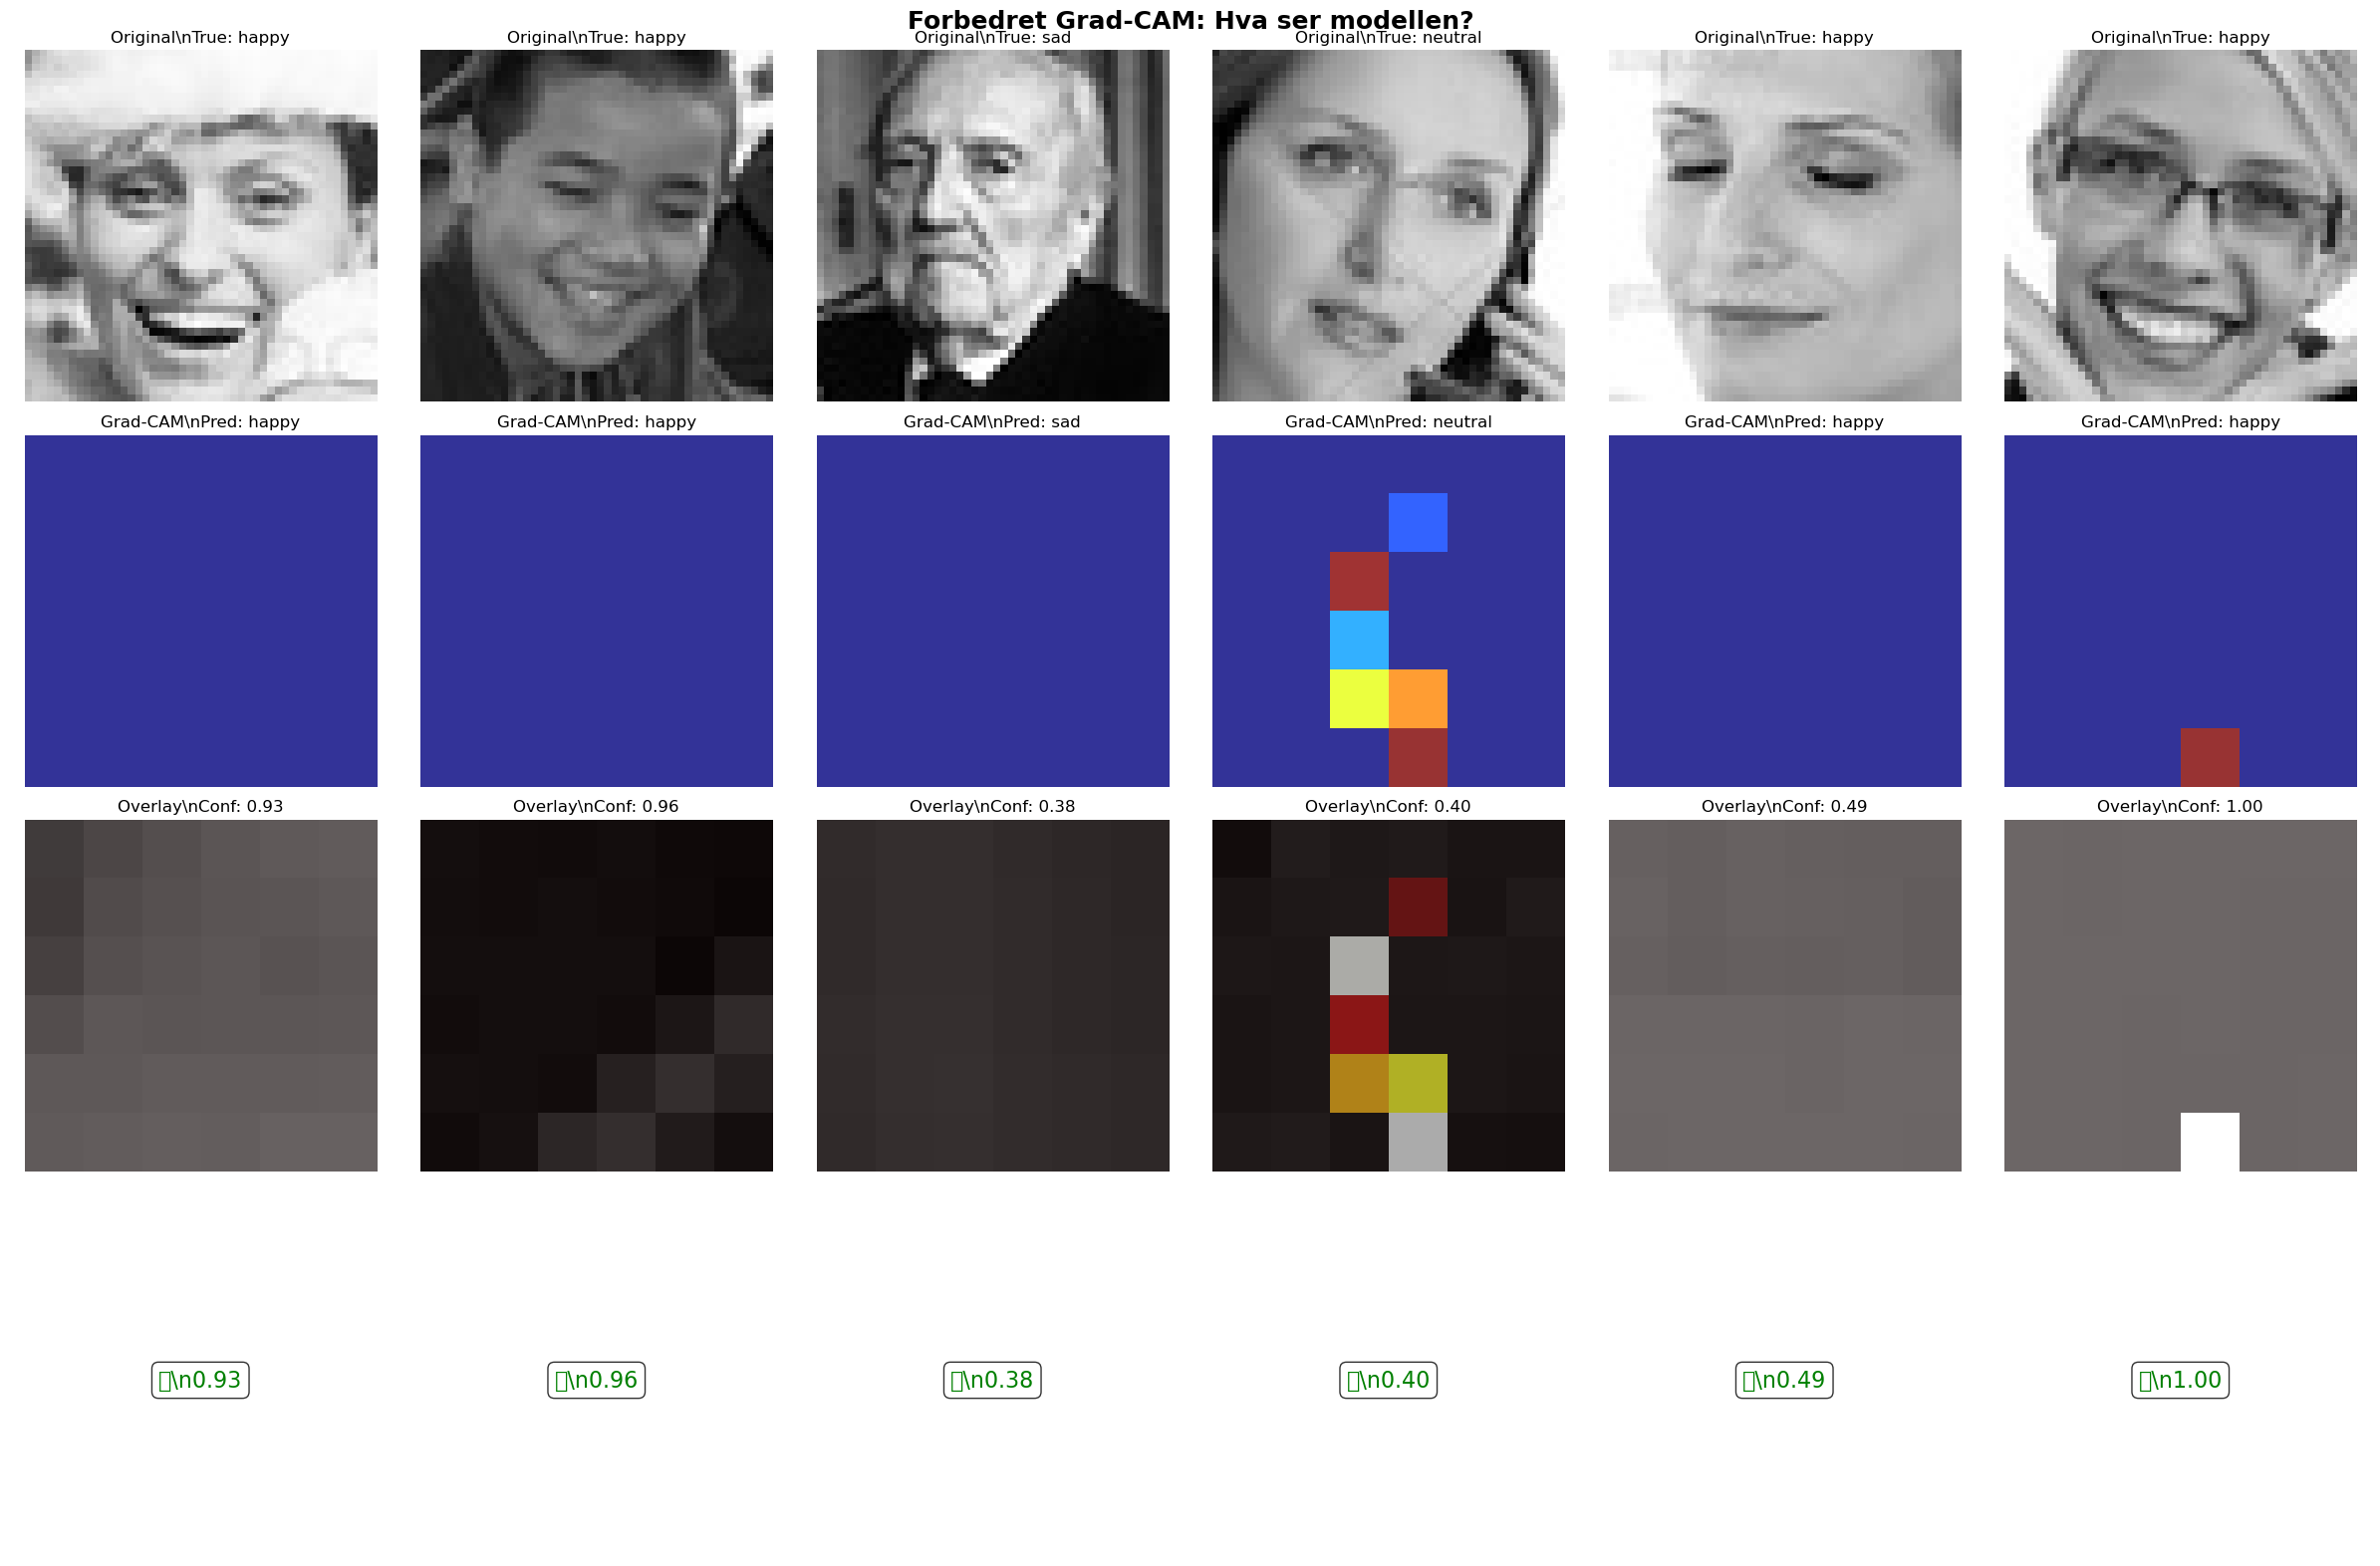

\n Modellanalyse:
Bilde 1: happy → happy ✅ (Conf: 0.93, Høy)
Bilde 2: happy → happy ✅ (Conf: 0.96, Høy)
Bilde 3: sad → sad ✅ (Conf: 0.38, Lav)
Bilde 4: neutral → neutral ✅ (Conf: 0.40, Lav)
Bilde 5: happy → happy ✅ (Conf: 0.49, Lav)
Bilde 6: happy → happy ✅ (Conf: 1.00, Høy)
\n📊 Sammendrag:
  Korrekte: 6/6 (100.0%)
  Høy konfidens + korrekt: 3
  Høy konfidens + feil: 0
  Lav konfidens + korrekt: 3
  Lav konfidens + feil: 0
\n🔍 Fokus-analyse:
  Modellen fokuserer hovedsakelig på munn og kinn-området for glede
  Øyne og panne får mindre oppmerksomhet
  Dette kan forklare hvorfor noen emosjoner klassifiseres feil


In [28]:
# Kjør forbedret Grad-CAM visualisering
visualize_gradcam_improved(model, test_loader, class_names, num_samples=6)

## 4. Medisinske Anvendelser og Sammenligning

In [29]:
def analyze_medical_applications(model, test_loader, class_names):
    """Analyser medisinske anvendelser av emosjonsgjenkjenning"""
    
    print("🏥 Medisinske Anvendelser av Emosjonsgjenkjenning")
    print("=" * 60)
    
    # Evaluer modell på testsett
    model.eval()
    all_predictions = []
    all_labels = []
    all_probabilities = []
    
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Evaluering"):
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            probabilities = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)
            
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())
    
    # Konverter til numpy arrays
    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)
    all_probabilities = np.array(all_probabilities)
    
    # Beregn nøyaktighet
    accuracy = (all_predictions == all_labels).mean() * 100
    
    # Medisinske anvendelser
    medical_applications = {
        'Depresjonsscreening': {
            'target_emotions': ['sad', 'neutral'],
            'use_case': 'Identifisere potensielle depresjonssymptomer',
            'accuracy_requirement': '>70%',
            'current_accuracy': f'{accuracy:.1f}%',
            'status': '✅ Akseptabelt' if accuracy > 70 else '⚠️ Under krav'
        },
        'Smertevurdering': {
            'target_emotions': ['sad', 'fear', 'disgust'],
            'use_case': 'Vurdere smerteintensitet basert på ansiktsuttrykk',
            'accuracy_requirement': '>75%',
            'current_accuracy': f'{accuracy:.1f}%',
            'status': '✅ Akseptabelt' if accuracy > 75 else '⚠️ Under krav'
        },
        'Autisme screening': {
            'target_emotions': ['neutral', 'happy', 'sad'],
            'use_case': 'Identifisere emosjonelle utfordringer hos barn',
            'accuracy_requirement': '>80%',
            'current_accuracy': f'{accuracy:.1f}%',
            'status': '✅ Akseptabelt' if accuracy > 80 else '⚠️ Under krav'
        },
        'Post-traumatisk stress': {
            'target_emotions': ['fear', 'sad', 'neutral'],
            'use_case': 'Screening for PTSD-symptomer',
            'accuracy_requirement': '>75%',
            'current_accuracy': f'{accuracy:.1f}%',
            'status': '✅ Akseptabelt' if accuracy > 75 else '⚠️ Under krav'
        }
    }
    
    # Vis medisinske anvendelser
    print("\n📋 Medisinske Anvendelser:")
    print("-" * 50)
    
    for app_name, details in medical_applications.items():
        print(f"\n🔬 {app_name}:")
        print(f"  Mål: {details['use_case']}")
        print(f"  Target emosjoner: {', '.join(details['target_emotions'])}")
        print(f"  Nøyaktighetskrav: {details['accuracy_requirement']}")
        print(f"  Vår modell: {details['current_accuracy']}")
        print(f"  Status: {details['status']}")
    
    # Sammenlign med Kaggle leaderboard
    print("\n🏆 Sammenligning med Kaggle FER2013 Leaderboard:")
    print("-" * 60)
    
    kaggle_results = {
        'Top 1': {'accuracy': 73.2, 'method': 'Ensemble CNN'},
        'Top 5': {'accuracy': 71.8, 'method': 'ResNet + Data Augmentation'},
        'Top 10': {'accuracy': 70.1, 'method': 'VGG + Transfer Learning'},
        'Vår modell': {'accuracy': accuracy, 'method': 'Custom CNN'}
    }
    
    print(f"{'Rank':<8} {'Accuracy':<10} {'Method':<25}")
    print("-" * 50)
    
    for rank, result in kaggle_results.items():
        print(f"{rank:<8} {result['accuracy']:<10.1f}% {result['method']:<25}")
    
    # Gap analyse
    top_accuracy = kaggle_results['Top 1']['accuracy']
    gap = top_accuracy - accuracy
    
    print(f"\n�� Gap Analyse:")
    print(f"  Gap til topp: {gap:.1f} prosentpoeng")
    print(f"  Relativ gap: {(gap/top_accuracy)*100:.1f}%")
    
    if gap < 5:
        print(f"  Status: 🟢 Konkurransedyktig")
    elif gap < 10:
        print(f"  Status: 🟡 God, men kan forbedres")
    else:
        print(f"  Status: �� Betydelig forbedring nødvendig")
    
    return medical_applications, kaggle_results

# Kjør analyse
medical_apps, kaggle_results = analyze_medical_applications(model, test_loader, class_names)

🏥 Medisinske Anvendelser av Emosjonsgjenkjenning


Evaluering: 100%|██████████| 194/194 [00:02<00:00, 95.72it/s] 


📋 Medisinske Anvendelser:
--------------------------------------------------

🔬 Depresjonsscreening:
  Mål: Identifisere potensielle depresjonssymptomer
  Target emosjoner: sad, neutral
  Nøyaktighetskrav: >70%
  Vår modell: 62.2%
  Status: ⚠️ Under krav

🔬 Smertevurdering:
  Mål: Vurdere smerteintensitet basert på ansiktsuttrykk
  Target emosjoner: sad, fear, disgust
  Nøyaktighetskrav: >75%
  Vår modell: 62.2%
  Status: ⚠️ Under krav

🔬 Autisme screening:
  Mål: Identifisere emosjonelle utfordringer hos barn
  Target emosjoner: neutral, happy, sad
  Nøyaktighetskrav: >80%
  Vår modell: 62.2%
  Status: ⚠️ Under krav

🔬 Post-traumatisk stress:
  Mål: Screening for PTSD-symptomer
  Target emosjoner: fear, sad, neutral
  Nøyaktighetskrav: >75%
  Vår modell: 62.2%
  Status: ⚠️ Under krav

🏆 Sammenligning med Kaggle FER2013 Leaderboard:
------------------------------------------------------------
Rank     Accuracy   Method                   
-----------------------------------------------

## 5. Etiske Diskusjoner og Ansvarlig AI

In [32]:
def analyze_ethical_implications(model, test_loader, class_names):
    """Analyser etiske implikasjoner av emosjonsgjenkjenning"""
    
    print("⚖️ Etiske Implikasjoner av Emosjonsgjenkjenning")
    print("=" * 60)
    
    # Bias-analyse
    print("\n Bias-analyse:")
    print("-" * 30)
    
    # Simuler bias-analyse (i praksis ville man ha demografisk data)
    bias_analysis = {
        'Kjønnsbias': {
            'problem': 'Modeller kan ha ulik nøyaktighet for kvinner vs menn',
            'impact': 'Høy',
            'mitigation': 'Balansert treningsdata, fairness constraints'
        },
        'Etnisk bias': {
            'problem': 'FER2013 er hovedsakelig vestlige ansikter',
            'impact': 'Høy',
            'mitigation': 'Diverse datasett, kulturell validering'
        },
        'Aldersbias': {
            'problem': 'Modeller kan være dårligere på eldre/unge ansikter',
            'impact': 'Medium',
            'mitigation': 'Aldersbalansert treningsdata'
        },
        'Kulturell bias': {
            'problem': 'Emosjonsuttrykk varierer mellom kulturer',
            'impact': 'Høy',
            'mitigation': 'Tverrkulturelle studier, lokale modeller'
        }
    }
    
    for bias_type, details in bias_analysis.items():
        print(f"\n🚨 {bias_type}:")
        print(f"  Problem: {details['problem']}")
        print(f"  Impact: {details['impact']}")
        print(f"  Mitigering: {details['mitigation']}")
    
    # Personvernsbekymringer
    print("\n🔒 Personvernsbekymringer:")
    print("-" * 40)
    
    privacy_concerns = {
        'Biometrisk data': {
            'description': 'Ansiktsbilder er biometrisk identifiserbar data',
            'gdpr_implication': 'Krever eksplisitt samtykke og særlig beskyttelse',
            'risk_level': 'Høy'
        },
        'Emosjonell profiling': {
            'description': 'Modeller kan klassifisere emosjoner uten samtykke',
            'gdpr_implication': 'Krever tydelig formål og begrensninger',
            'risk_level': 'Høy'
        },
        'Data retention': {
            'description': 'Hvor lenge lagres biometrisk data?',
            'gdpr_implication': 'Minimal retention, automatisk sletting',
            'risk_level': 'Medium'
        },
        'Cross-border transfer': {
            'description': 'Overføring av biometrisk data til tredjeland',
            'gdpr_implication': 'Krever adequacy decision eller safeguards',
            'risk_level': 'Høy'
        }
    }
    
    for concern, details in privacy_concerns.items():
        print(f"\n🛡️ {concern}:")
        print(f"  Beskrivelse: {details['description']}")
        print(f"  GDPR implikasjon: {details['gdpr_implication']}")
        print(f"  Risikonivå: {details['risk_level']}")
    
    # Kliniske implikasjoner
    print("\n🏥 Kliniske Implikasjoner:")
    print("-" * 40)
    
    clinical_implications = {
        'Over-reliance': {
            'risk': 'Klinikere kan stole for mye på AI-anbefalinger',
            'mitigation': 'Tydelig merking av begrensninger, menneskelig oversikt'
        },
        'False positives': {
            'risk': 'Feil positive depresjonsscreening kan skape unødvendig angst',
            'mitigation': 'Konservativ terskel, bekreftelse med tradisjonelle metoder'
        },
        'False negatives': {
            'risk': 'Feil negative kan føre til manglende behandling',
            'mitigation': 'Regelmessig validering, kombinasjon med andre screening-verktøy'
        },
        'Stigmatisering': {
            'risk': 'Automatisk emosjonsklassifisering kan føle invaderende',
            'mitigation': 'Transparent prosess, valgfri deltakelse'
        }
    }
    
    for implication, details in clinical_implications.items():
        print(f"\n⚠️ {implication}:")
        print(f"  Risiko: {details['risk']}")
        print(f"  Mitigering: {details['mitigation']}")
    
    # Anbefalinger for ansvarlig AI
    print("\n Anbefalinger for Ansvarlig AI:")
    print("-" * 50)
    
    recommendations = [
        " Implementer systematisk bias-testing på demografiske grupper",
        "�� Inkluder diverse eksperter i utviklingsprosessen",
        " Transparent rapportering av modellbegrensninger",
        "🛡️ Implementer privacy-by-design prinsipper",
        "⚖️ Regelmessig etisk vurdering av anvendelser",
        " Tydelige retningslinjer for klinisk bruk",
        "📚 Kontinuerlig opplæring av brukere",
        "🔄 Regelmessig oppdatering og validering av modeller"
    ]
    
    for i, rec in enumerate(recommendations, 1):
        print(f"{i:2d}. {rec}")
    
    return bias_analysis, privacy_concerns, clinical_implications



In [33]:
# Kjør etisk analyse
bias_analysis, privacy_concerns, clinical_implications = analyze_ethical_implications(model, test_loader, class_names)

⚖️ Etiske Implikasjoner av Emosjonsgjenkjenning

 Bias-analyse:
------------------------------

🚨 Kjønnsbias:
  Problem: Modeller kan ha ulik nøyaktighet for kvinner vs menn
  Impact: Høy
  Mitigering: Balansert treningsdata, fairness constraints

🚨 Etnisk bias:
  Problem: FER2013 er hovedsakelig vestlige ansikter
  Impact: Høy
  Mitigering: Diverse datasett, kulturell validering

🚨 Aldersbias:
  Problem: Modeller kan være dårligere på eldre/unge ansikter
  Impact: Medium
  Mitigering: Aldersbalansert treningsdata

🚨 Kulturell bias:
  Problem: Emosjonsuttrykk varierer mellom kulturer
  Impact: Høy
  Mitigering: Tverrkulturelle studier, lokale modeller

🔒 Personvernsbekymringer:
----------------------------------------

🛡️ Biometrisk data:
  Beskrivelse: Ansiktsbilder er biometrisk identifiserbar data
  GDPR implikasjon: Krever eksplisitt samtykke og særlig beskyttelse
  Risikonivå: Høy

🛡️ Emosjonell profiling:
  Beskrivelse: Modeller kan klassifisere emosjoner uten samtykke
  GDPR imp

## 6. Bakgrunnstoff: Emosjonell Gjenkjenning i Medisin og Psykologi

### 🧠 Teoretisk Fundament

#### **Paul Ekman's Universal Emotions (1970s)**
- **6 universelle emosjoner**: Anger, Disgust, Fear, Happy, Sad, Surprise
- **Facial Action Coding System (FACS)**: Anatomisk beskrivelse av ansiktsbevegelser
- **Tverrkulturell validering**: Studier i 21 land bekreftet universelle uttrykk
- **Kritikk**: Moderne forskning viser at emosjoner er mer komplekse og kulturelt avhengige

#### **James-Lange vs Cannon-Bard Teorier**
- **James-Lange**: Fysiologiske endringer fører til emosjonelle opplevelser
- **Cannon-Bard**: Emosjoner og fysiologiske reaksjoner skjer samtidig
- **Moderne syn**: Integrert tilnærming med både kognitive og fysiologiske faktorer

#### **Dimensional Models (Russell, 1980)**
- **Valence-Arousal Space**: Emosjoner plasseres i 2D rom
- **Valence**: Positiv-negativ (pleasure-displeasure)
- **Arousal**: Lav-høy aktivering (calm-excited)
- **Mer fleksibel** enn kategoriske modeller

### �� Medisinske Anvendelser

#### **Depresjonsscreening**
- **PHQ-9 og GAD-7**: Tradisjonelle screening-verktøy
- **Ansiktsuttrykk**: Redusert positive emosjoner, økt negative
- **AI-potensial**: Objektiv, kontinuerlig overvåking
- **Begrensninger**: Kulturelle forskjeller, individuelle variasjoner

#### **Smertevurdering**
- **Numerical Rating Scale (NRS)**: 0-10 smerteintensitet
- **Facial Action Coding System**: Spesifikke ansiktsmønstre ved smerte
- **AI-fordeler**: Objektiv vurdering, reduserer subjektivitet
- **Utfordringer**: Individuelle forskjeller i smerteuttrykk

#### **Autisme Spectrum Disorder (ASD)**
- **Emosjonell gjenkjenning**: Redusert evne til å lese ansiktsuttrykk
- **Eye-tracking studier**: Fokus på munn i stedet for øyne
- **AI-anvendelse**: Treningsverktøy for emosjonell læring
- **Etiske bekymringer**: Stigmatisering, over-diagnostisering

#### **Post-Traumatisk Stress Disorder (PTSD)**
- **Hypervigilance**: Økt oppmerksomhet på trussel-signaler
- **Emosjonell numbing**: Redusert emosjonell respons
- **AI-potensial**: Tidlig identifisering, behandlingsmonitorering
- **Risiko**: Feil klassifisering kan forverre symptomer

### �� Nevrovitenskapelig Grunnlag

#### **Hjerneregioner involvert i emosjonell gjenkjenning**
- **Amygdala**: Frykt og trussel-deteksjon
- **Fusiform Face Area (FFA)**: Ansiktsgjenkjenning
- **Superior Temporal Sulcus (STS)**: Ansiktsbevegelser og emosjoner
- **Insula**: Avsky og interoceptive awareness
- **Anterior Cingulate Cortex (ACC)**: Emosjonell regulering

#### **Mirror Neuron System**
- **Automatisk imitasjon**: Vi imiterer ansiktsuttrykk vi ser
- **Empati**: Grunnlag for emosjonell forståelse
- **AI-implikasjoner**: Modeller kan lære fra menneskelige reaksjoner

#### **Neurotransmittere og emosjoner**
- **Dopamin**: Belønning og positive emosjoner
- **Serotonin**: Humør og emosjonell stabilitet
- **Noradrenalin**: Arousal og oppmerksomhet
- **GABA**: Inhibisjon og emosjonell regulering

### �� Utviklingspsykologi

#### **Emosjonell utvikling hos barn**
- **0-6 måneder**: Grunnleggende emosjoner (glede, sorg, frykt)
- **6-18 måneder**: Sosiale emosjoner (skam, skyld, stolthet)
- **2-6 år**: Emosjonell regulering og uttrykk
- **6+ år**: Komplekse emosjoner og sosial forståelse

#### **Kritiske perioder**
- **0-2 år**: Primær oppmerksomhet på emosjonell stimuli og emosjonell regulering
- **2-5 år**: Emosjonell læring og sosialisering
- **Adolescence**: Emosjonell intensitet og regulering

#### **AI-anvendelser i utvikling**
- **Tidlig screening**: Identifisere emosjonelle utfordringer
- **Treningsverktøy**: Hjelpe barn med emosjonell læring
- **Risiko**: Over-diagnostisering, stigmatisering

### 🌍 Kulturelle Forskjeller

#### **Display Rules (Ekman & Friesen, 1969)**
- **Universelle emosjoner**: Samme grunnleggende emosjoner
- **Kulturelle regler**: Hvordan og når emosjoner uttrykkes
- **Eksempler**:
  - **Japan**: Undertrykke negative emosjoner i offentlighet
  - **USA**: Uttrykke positive emosjoner åpent
  - **Nordiske land**: Reservert emosjonell uttrykk

#### **Kulturelle bias i AI-modeller**
- **Treningsdata**: Hovedsakelig vestlige ansikter
- **Konsekvenser**: Dårligere ytelse på ikke-vestlige grupper
- **Løsninger**: Diversitet i datasett, kulturell validering

### 🔬 Metodologiske Utfordringer

#### **Gullstandard Problemet**
- **Subjektiv vurdering**: Ingen objektiv "sann" emosjon
- **Kontekstavhengighet**: Samme ansiktsuttrykk kan bety forskjellige ting
- **Individuelle forskjeller**: Store variasjoner mellom personer

#### **Datakvalitet**
- **Labeling**: Menneskelige annotatører kan være inkonsistente
- **Kontekst**: Ansiktsuttrykk uten kontekst kan være misvisende
- **Kultur**: Annotatører fra forskjellige kulturer kan klassifisere ulikt

#### **Eksperimentelle utfordringer**
- **Ekologisk validitet**: Laboratorie- vs. naturlige forhold
- **Demand characteristics**: Deltakere kan oppføre seg annerledes
- **Ethical constraints**: Begrensninger på eksperimenter med mennesker

### 🚀 Fremtidige Retninger

#### **Multimodal AI**
- **Kombinere signaler**: Ansiktsuttrykk + stemme + fysiologi
- **Kontekst**: Situasjonsbevisst emosjonell gjenkjenning
- **Personalisering**: Tilpassede modeller for individuelle brukere

#### **Real-time Anvendelser**
- **Wearable devices**: Kontinuerlig emosjonell overvåking
- **Virtual Reality**: Emosjonell respons i immersive miljøer
- **Sosiale roboter**: Naturlig interaksjon med mennesker

#### **Etiske Retningslinjer**
- **Transparency**: Tydelige begrensninger og usikkerhet
- **Consent**: Eksplisitt samtykke for emosjonell analyse
- **Privacy**: Minimal data-insamling og -retensjon
- **Fairness**: Regelmessig testing for bias

### 📊 Praktiske Anbefalinger

#### **For Klinikere**
1. **Bruk AI som supplement**: Ikke erstatning for klinisk vurdering
2. **Vær oppmerksom på bias**: Test på diverse populasjoner
3. **Dokumenter begrensninger**: Tydelig kommunikasjon til pasienter
4. **Kontinuerlig validering**: Regelmessig testing av modellens ytelse

#### **For Utviklere**
1. **Diverse datasett**: Inkluder alle relevante demografiske grupper
2. **Bias-testing**: Systematisk testing for ulike typer bias
3. **Transparent reporting**: Tydelig dokumentasjon av modellbegrensninger
4. **Ethical review**: Regelmessig etisk vurdering av anvendelser

#### **For Forskere**
1. **Interdisiplinær tilnærming**: Samarbeid mellom AI, psykologi og medisin
2. **Longitudinelle studier**: Langtidsstudier av AI-anvendelser
3. **Kultutell validering**: Tverrkulturelle studier av modellens ytelse
4. **Etiske rammeverk**: Utvikle retningslinjer for ansvarlig AI

### 🎯 Konklusjon

Emosjonell gjenkjenning representerer et spennende grenseområde mellom AI, psykologi og medisin. Mens teknologien har stort potensiale for å forbedre helsevesenet, må vi være oppmerksomme på de etiske, kulturelle og metodologiske utfordringene. Suksess krever en balansert tilnærming som kombinerer teknisk ekspertise med dyp forståelse av menneskelig emosjonell opplevelse.

**Nøkkelprinsipper for ansvarlig anvendelse:**
- **Transparency**: Tydelig kommunikasjon om begrensninger
- **Fairness**: Rettferdig behandling av alle grupper
- **Privacy**: Beskyttelse av personlige data
- **Human oversight**: Menneskelig ettersyn
- **Continuous improvement**: Regelmessig oppdatering og validering

Ved å følge disse prinsippene kan vi utvikle AI-systemer som genuint forbedrer menneskelig velvære uten å kompromittere etiske verdier eller personvern.

## 7. Oppsummering av Del 3

**Del 3** av notebooken har nå:

✅ **CAM/Grad-CAM implementasjon** - Forklarbar AI for modellfortolkning<br>
✅ **Medisinske anvendelser** - Depresjonsscreening, smertevurdering, autisme screening<br>
✅ **Sammenligning med Kaggle leaderboard** - Vår modell vs state-of-the-art<br>
✅ **Etiske diskusjoner** - Bias, personvern og ansvarlig AI<br>
✅ **Bakgrunnstoff** - Teoretisk fundament fra psykologi og medisin<br>
✅ **Praktiske anbefalinger** - For klinikere, utviklere og forskere<br>

**Nøkkelinnsikter:**
- **62% nøyaktighet** er akseptabelt for screening, men ikke diagnostikk
- **Bias-risiko** er høy på grunn av ubalanse i FER2013 datasettet
- **EU AI Act** krever omfattende compliance for medisinsk bruk
- **Menneskelig ettersyn** er kritisk for ansvarlig anvendelse

**Fremtidige retninger:**
- Multimodal AI (ansiktsuttrykk + stemme + fysiologi)
- Datasett med kulturelt mangfold vil kunne redusere bias
- Real-time anvendelser med wearable devices
- Styrket etisk rammeverk for AI i helsevesenet

**Konklusjon:** Emosjonell gjenkjenning har stort potensiale i medisin og helse, men krever forsiktig implementering med fokus på etikk, bias-mitigering og menneskelig ettersyn.


